# Implementation and example of various skill scores

In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
from valenspy.preprocessing_tasks.select import select_point
from valenspy.diagnostic_functions import mean_bias, mean_absolute_error, root_mean_square_error, spearman_correlation, perkins_skill_score
from pathlib import Path


import xarray as xr
import numpy as np



# define machine name - used for paths of (observational) datasets
machine = 'hortense'

## 0. Settings

In [2]:
# define points to abstract (lon, lat)
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'betrix'    : (5.25, 49.854),
    'north_sea' : (2.465, 51.63),
}

point_id = "opwijk"
point_coord = d_point_coords[point_id]

In [3]:
model = 'CCLM'
ref_dataset = 'ERA5'
variable = 'tas'
experiment = "EUR11_NU_TT_EC_TSO"
daily_statistic = "mean"

manager = vp.InputManager(machine=machine)

ds_mod = manager.load_data(model, [variable], freq="daily", path_identifiers=[experiment, daily_statistic])
ds_obs = manager.load_data(ref_dataset, variable, period=[1995,1995], freq="hourly", region="europe")
ds_obs = ds_obs.resample(time='1D').mean()


# for both datasets, select summer months (JJA)
ds_mod = ds_mod.sel(time=ds_mod.time.dt.month.isin([6,7,8]))
ds_obs = ds_obs.sel(time=ds_obs.time.dt.month.isin([6,7,8]))

# make sure both Datasets have the same daily time axis
ds_mod['time'] = ds_mod['time'].dt.floor('D')
ds_obs['time'] = ds_obs['time'].dt.floor('D')

# do point selection
ds_obs_point = select_point(ds_obs, point_coord)
ds_mod_point = select_point(ds_mod, point_coord, rotated_pole=True)

da_obs = ds_obs_point[variable].compute()
da_mod = ds_mod_point[variable].compute()


File paths found:
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/EUR11_NU_TT_EC_TSO/T_2M/daily/T_2M_daymean.nc
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
33.33% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole']
File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/2m_temperature/hourly/era5-hourly-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
100.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']


## 2. Skill score calculations
in this example, this means selecting the point data and corresponding time

In [4]:
def get_userdefined_binwidth(variable):
    
    # define bin width lookup table
    d_binwidth = { 
    'tas'    : 2,
    'tasmax' : 2,
    'tasmin' : 2,
    'ps'     : 500,
    'psl'    : 500,
    'clt'    : 10,
    'clh'    : 10,
    'clm'    : 10,
    'cll'    : 10 }

    if variable in d_binwidth: 
        return d_binwidth[variable]
    else:

        print(f"{variable} has no defined binwidths")





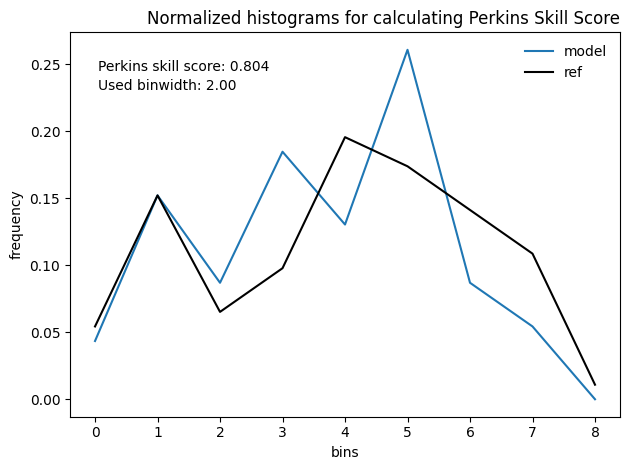

In [5]:
from valenspy.diagnostic_visualizations import visualize_perkins_skill_score

visualize_perkins_skill_score(da_mod, da_obs, binwidth=get_userdefined_binwidth(variable))


## Skill scores overview

In [12]:
from IPython.display import Markdown, display


# Calculate metrics
bias = mean_bias(da_mod, da_obs)
mae = mean_absolute_error(da_mod, da_obs)
mae_90pctl = mean_absolute_error(da_mod, da_obs, percentile=0.9)
mae_99pctl = mean_absolute_error(da_mod, da_obs, percentile=0.99)
mae_10pctl = mean_absolute_error(da_mod, da_obs, percentile=0.1)
mae_1pctl = mean_absolute_error(da_mod, da_obs, percentile=0.01)
rmse = root_mean_square_error(da_mod, da_obs)
corr = spearman_correlation(da_mod, da_obs)
binwidth = get_userdefined_binwidth(variable)  # Replace `None` with actual variable if needed
pss_score, _, _, _ = perkins_skill_score(da_mod, da_obs, binwidth=binwidth)

# Print metrics in Markdown table format

# Create Markdown table with dynamic values
markdown_table = f"""
Metrics for **{da_mod.long_name}** ({variable})

{experiment} compared to {ref_dataset}

| Metric                   |       |
|--------------------------|------------|
| Mean Bias                | {bias:.2f} {da_mod.units}  |
| Mean Absolute Error      | {mae:.2f} {da_mod.units}  |
| MAE at 90th Percentile    | {mae_90pctl:.2f} {da_mod.units}  |
| MAE at 99th Percentile    | {mae_99pctl:.2f} {da_mod.units}  |
| MAE at 10th Percentile    | {mae_10pctl:.2f} {da_mod.units} |
| MAE at 1st Percentile     | {mae_1pctl:.2f} {da_mod.units} |
| Root Mean Square Error   | {rmse:.2f} {da_mod.units}  |
| Spearman Correlation     | {corr:.2f}   |
| Perkins Skill Score      | {pss_score:.2f}   |
"""

# Display Markdown in the notebook
display(Markdown(markdown_table))


Metrics for **Near-Surface Air Temperature** (tas)

EUR11_NU_TT_EC_TSO compared to ERA5

| Metric                   |       |
|--------------------------|------------|
| Mean Bias                | -0.75 K  |
| Mean Absolute Error      | 1.33 K  |
| MAE at 90th Percentile    | 1.59 K  |
| MAE at 99th Percentile    | 1.01 K  |
| MAE at 10th Percentile    | 0.03 K |
| MAE at 1st Percentile     | 0.49 K |
| Root Mean Square Error   | 1.73 K  |
| Spearman Correlation     | 0.92   |
| Perkins Skill Score      | 0.80   |


'Near-Surface Air Temperature'